In [108]:
import rpy2
import rpy2.robjects.lib.ggplot2 as ggplot2
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
base = importr('base')

# the base of rpy2 plotting is matplotlib, thus we need to declare
# it inline in order to see the plots in the notebook
%matplotlib inline

# we need to activate the automatic conversion for pandas
from rpy2.robjects import pandas2ri
pandas2ri.activate()

# load the needed extension for the %%R cell magic
%load_ext rpy2.ipython

import numpy as np
import pandas as pd
import glob
import toml

%config IPCompleter.greedy=True

from IPython.display import display, HTML
display(HTML("<style>pre { white-space: pre !important; }</style>"))

import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [146]:
rootdir = "/Users/akshay/research/burrito"
outdirs = ["elk-2023-09-15-8540e00", "check-producer-1eb988c", "check-producer-615a756"]

In [147]:
def read_toml(cfg):
    c = toml.load(cfg)
    num_lps = len(c['machines']['logparser'])
    c['exp']['logparser']['num'] = num_lps
    return c['exp']

def merge_tomls(cfgs):
    merged_cfg = {}
    for cfg in cfgs:
        for key in cfg:
            if key in merged_cfg:
                if type(cfg[key]) != type(merged_cfg[key]):
                    raise Exception(f"mismatched config types: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == int and merged_cfg[key] != cfg[key]:
                    raise Exception(f"int-valued configs must match: {cfg[key]} vs {merged_cfg[key]}")
                if type(cfg[key]) == list:
                    merged_cfg[key] = list(set(cfg[key]).union(set(merged_cfg[key])))
            else:
                merged_cfg[key] = cfg[key]
    return merged_cfg

tomls = {}
for outdir in outdirs:
    od = f"{rootdir}/{outdir}"
    cfgs = glob.glob(f"{od}/*.toml")
    tomls[outdir] = merge_tomls([read_toml(t) for t in cfgs])

tomls

{'elk-2023-09-15-8540e00': {'iterations': 1,
  'pubsub-kafka': [True, False],
  'local-fastpath': [True, False],
  'encrypt': ['allow-none', 'auto-only', 'tls-only', 'quic-only'],
  'producer': {'allow-client-sharding': [True, False],
   'msg-limit': ['30s'],
   'msg-interarrival-ms': [50, 100]},
  'logingest': {'workers': [2]},
  'logparser': {'machines': [1],
   'processes-per-machine': [1, 2],
   'interval-ms': [100, 500],
   'num': 1}},
 'check-producer-1eb988c': {'iterations': 1,
  'pubsub-kafka': [False],
  'local-fastpath': [True],
  'encrypt': ['allow-none', 'autoonly'],
  'producer': {'allow-client-sharding': [True],
   'msg-limit': [2500],
   'msg-interarrival-ms': [50, 100]},
  'logingest': {'workers': [2]},
  'logparser': {'machines': [1],
   'processes-per-machine': [1],
   'interval-ms': [100],
   'num': 1}},
 'check-producer-615a756': {'iterations': 1,
  'pubsub-kafka': [False],
  'local-fastpath': [True],
  'encrypt': ['allow-none', 'autoonly'],
  'producer': {'allow-cl

In [148]:
# copied from elk-app.py
import itertools
def iter_confs(exp, outdir):
    i = exp['iterations']
    prod = exp['producer']
    ing = exp['logingest']
    par = exp['logparser']
    confs = itertools.product(
        exp['pubsub-kafka'],
        exp['local-fastpath'],
        exp['encrypt'],
        prod['allow-client-sharding'],
        prod['msg-limit'],
        prod['msg-interarrival-ms'],
        ing['workers'],
        par['machines'],
        par['processes-per-machine'],
        par['interval-ms'],
        range(i),
    )
    for conf in confs:
        exp = {
                'pubsub-kafka': conf[0],
                'local-fastpath': conf[1],
                'encrypt': conf[2],
                'producer': {
                    'allow-client-sharding': conf[3],
                    'msg-limit': conf[4],
                    'msg-interarrival-ms': conf[5],
                },
                'logingest': {
                    'workers': conf[6],
                },
                'logparser': {
                    'num': par['num'],
                    'machines': conf[7],
                    'processes-per-machine': conf[8],
                    'interval-ms': conf[9],
                },
                'iteration': conf[10],
        }
        if type(exp['producer']['msg-limit']) == str:
            assert exp['producer']['msg-limit'][-1] == 's', 'time-based msg-limit must be in seconds'
            target_seconds = int(exp['producer']['msg-limit'][:-1])
            inter_seconds = float(int(exp['producer']['msg-interarrival-ms'])) / 1000
            exp['producer']['msg-limit'] = int(target_seconds / inter_seconds) * 16
        template = (
            "{rootdir}/{outdir}/"
            + "kfka={kafka}-"
            + "fp={localfp}-"
            + "cshd={client_shard}-"
            + "enc={encrypt}-"
            + "nmsg={num_msg}-"
            + "intms={msg_inter_ms}-"
            + "iwrk={ingest_workers}-"
            + "pn={parser_machines}-"
            + "pps={parser_procs}-"
            + "prpintms={parser_report_interval_ms}-"
            + "i={i}")
        desc = template.format(
            rootdir=rootdir, outdir=outdir,
            kafka=exp['pubsub-kafka'],
            localfp=exp['local-fastpath'],
            encrypt=exp['encrypt'].replace('-',''),
            client_shard=exp['producer']['allow-client-sharding'],
            num_msg=exp['producer']['msg-limit'],
            msg_inter_ms=exp['producer']['msg-interarrival-ms'],
            ingest_workers=exp['logingest']['workers'],
            parser_machines=exp['logparser']['machines'],
            parser_procs=exp['logparser']['processes-per-machine'],
            parser_report_interval_ms=exp['logparser']['interval-ms'],
            i=0,
        )
        exp['desc'] = desc
        exp['outdir'] = outdir
        yield exp

exps = list(itertools.chain.from_iterable(iter_confs(tomls[outdir], outdir) for outdir in tomls))
len(list(exps))

264

In [149]:
def read_exp(conf):
    outf_prefix = conf['desc']
    suffixes = (
        ["consumer.data", "logingest.data", "producer.data"] 
        + [f'logparser-{i}-{j}.data' for i in range(conf["logparser"]['num']) for j in range(conf['logparser']['processes-per-machine'])]
    )
    def x():
        for s in suffixes:
            df = pd.read_csv(f"{outf_prefix}-{s}")
            for c in conf:
                if type(conf[c]) == dict:
                    for i in conf[c]:
                        k = f"{c}-{i}"
                        if i == 'allow-client-sharding':
                            df[k] = 'clientshard' if conf[c][i] else 'noclientshard'
                        else:
                            df[k] = conf[c][i]
                else:
                    if c == 'pubsub-kafka':
                        df[c] = 'with-kafka' if conf[c] else 'without-kafka'
                    elif c == 'local-fastpath':
                        df[c] = 'with-fp' if conf[c] else 'without-fp'
                    else:
                        df[c] = conf[c]
            df['machine'] = s.split('.')[0]
            yield df
    return pd.concat(x())

df = pd.concat(read_exp(e) for e in exps)
pd.options.display.max_columns = 25
df

,since_start_us,tot_records,tot_bytes,records,bytes,elapsed_us,rate_records_per_sec,rate_bytes_per_sec,pubsub-kafka,local-fastpath,encrypt,producer-allow-client-sharding,producer-msg-limit,producer-msg-interarrival-ms,logingest-workers,logparser-num,logparser-machines,logparser-processes-per-machine,logparser-interval-ms,iteration,desc,outdir,machine
0,12806543,2,0.0,1,0.0,82.0,12134.449703,0.0,with-kafka,with-fp,allow-none,clientshard,9600,50,2,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-15-...,elk-2023-09-15-8540e00,consumer
1,12806618,3,0.0,1,0.0,101.0,9807.094452,0.0,with-kafka,with-fp,allow-none,clientshard,9600,50,2,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-15-...,elk-2023-09-15-8540e00,consumer
2,12806731,4,0.0,1,0.0,174.0,5717.356752,0.0,with-kafka,with-fp,allow-none,clientshard,9600,50,2,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-15-...,elk-2023-09-15-8540e00,consumer
3,12806821,5,0.0,1,0.0,234.0,4272.244509,0.0,with-kafka,with-fp,allow-none,clientshard,9600,50,2,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-15-...,elk-2023-09-15-8540e00,consumer
4,12806890,6,0.0,1,0.0,272.0,3666.051992,0.0,with-kafka,with-fp,allow-none,clientshard,9600,50,2,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-15-...,elk-2023-09-15-8540e00,consumer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,67308910,156,0.0,3,0.0,131.0,22737.952675,0.0,without-kafka,with-fp,autoonly,clientshard,2500,100,2,1,1,1,100,0,/Users/akshay/research/burrito/check-producer-...,check-producer-615a756,logparser-0-0
32,75336514,161,0.0,5,0.0,8027639.0,0.622848,0.0,without-kafka,with-fp,autoonly,clientshard,2500,100,2,1,1,1,100,0,/Users/akshay/research/burrito/check-producer-...,check-producer-615a756,logparser-0-0
33,77063341,162,0.0,1,0.0,1726971.0,0.579048,0.0,without-kafka,with-fp,autoonly,clientshard,2500,100,2,1,1,1,100,0,/Users/akshay/research/burrito/check-producer-...,check-producer-615a756,logparser-0-0
34,77462824,164,0.0,2,0.0,399565.0,5.005431,0.0,without-kafka,with-fp,autoonly,clientshard,2500,100,2,1,1,1,100,0,/Users/akshay/research/burrito/check-producer-...,check-producer-615a756,logparser-0-0


In [150]:
sample_df = df[
    (df["pubsub-kafka"] == "without-kafka")
    & (df["local-fastpath"] == "with-fp")
    & (df["logparser-interval-ms"] == 100)
    & (df["logparser-processes-per-machine"] == 1)
    & (df["producer-allow-client-sharding"] == "clientshard")]
sample_df

,since_start_us,tot_records,tot_bytes,records,bytes,elapsed_us,rate_records_per_sec,rate_bytes_per_sec,pubsub-kafka,local-fastpath,encrypt,producer-allow-client-sharding,producer-msg-limit,producer-msg-interarrival-ms,logingest-workers,logparser-num,logparser-machines,logparser-processes-per-machine,logparser-interval-ms,iteration,desc,outdir,machine
0,28578648,2,0.0,1,0.0,13615076.0,0.073448,0.0,without-kafka,with-fp,allow-none,clientshard,9600,50,2,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-15-...,elk-2023-09-15-8540e00,consumer
1,28578774,3,0.0,1,0.0,166.0,5991.216876,0.0,without-kafka,with-fp,allow-none,clientshard,9600,50,2,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-15-...,elk-2023-09-15-8540e00,consumer
2,29568973,4,0.0,1,0.0,990283.0,1.009812,0.0,without-kafka,with-fp,allow-none,clientshard,9600,50,2,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-15-...,elk-2023-09-15-8540e00,consumer
3,29569102,5,0.0,1,0.0,165.0,6026.746702,0.0,without-kafka,with-fp,allow-none,clientshard,9600,50,2,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-15-...,elk-2023-09-15-8540e00,consumer
4,30674950,6,0.0,1,0.0,1105946.0,0.904203,0.0,without-kafka,with-fp,allow-none,clientshard,9600,50,2,1,1,1,100,0,/Users/akshay/research/burrito/elk-2023-09-15-...,elk-2023-09-15-8540e00,consumer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31,67308910,156,0.0,3,0.0,131.0,22737.952675,0.0,without-kafka,with-fp,autoonly,clientshard,2500,100,2,1,1,1,100,0,/Users/akshay/research/burrito/check-producer-...,check-producer-615a756,logparser-0-0
32,75336514,161,0.0,5,0.0,8027639.0,0.622848,0.0,without-kafka,with-fp,autoonly,clientshard,2500,100,2,1,1,1,100,0,/Users/akshay/research/burrito/check-producer-...,check-producer-615a756,logparser-0-0
33,77063341,162,0.0,1,0.0,1726971.0,0.579048,0.0,without-kafka,with-fp,autoonly,clientshard,2500,100,2,1,1,1,100,0,/Users/akshay/research/burrito/check-producer-...,check-producer-615a756,logparser-0-0
34,77462824,164,0.0,2,0.0,399565.0,5.005431,0.0,without-kafka,with-fp,autoonly,clientshard,2500,100,2,1,1,1,100,0,/Users/akshay/research/burrito/check-producer-...,check-producer-615a756,logparser-0-0


/Users/akshay/Library/Python/3.9/lib/python/site-packages/rpy2/robjects/pandas2ri.py:56: UserWarning: DataFrame contains duplicated elements in the index, which will lead to loss of the row names in the resulting data.frame
  warnings.warn('DataFrame contains duplicated elements in the index, '


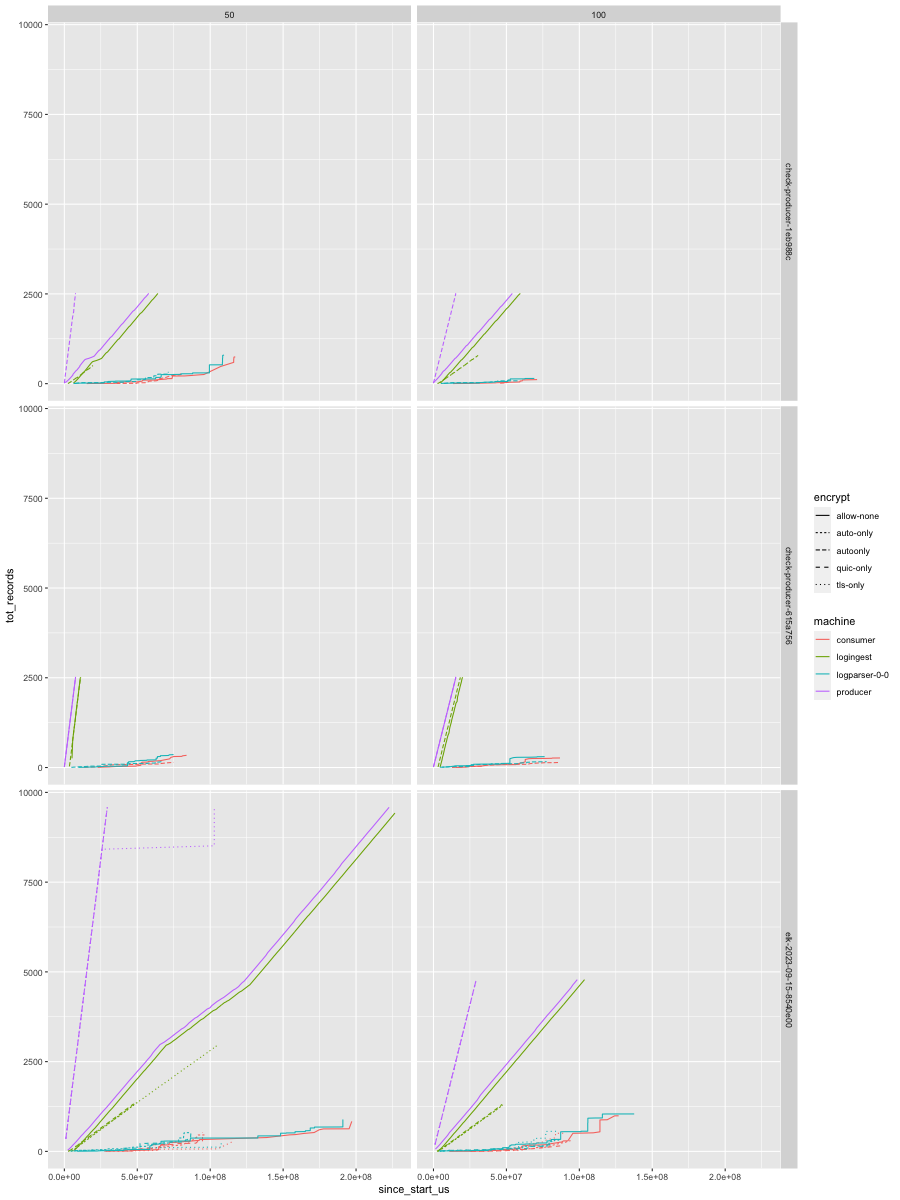

In [151]:
%%R -i sample_df -w 900 -h 1200

library(ggplot2)

ggplot(sample_df, aes(x=since_start_us, y=tot_records, colour=machine, linetype=encrypt)) +
  geom_line() +
  facet_grid(sample_df$outdir ~ sample_df$"producer-msg-interarrival-ms")

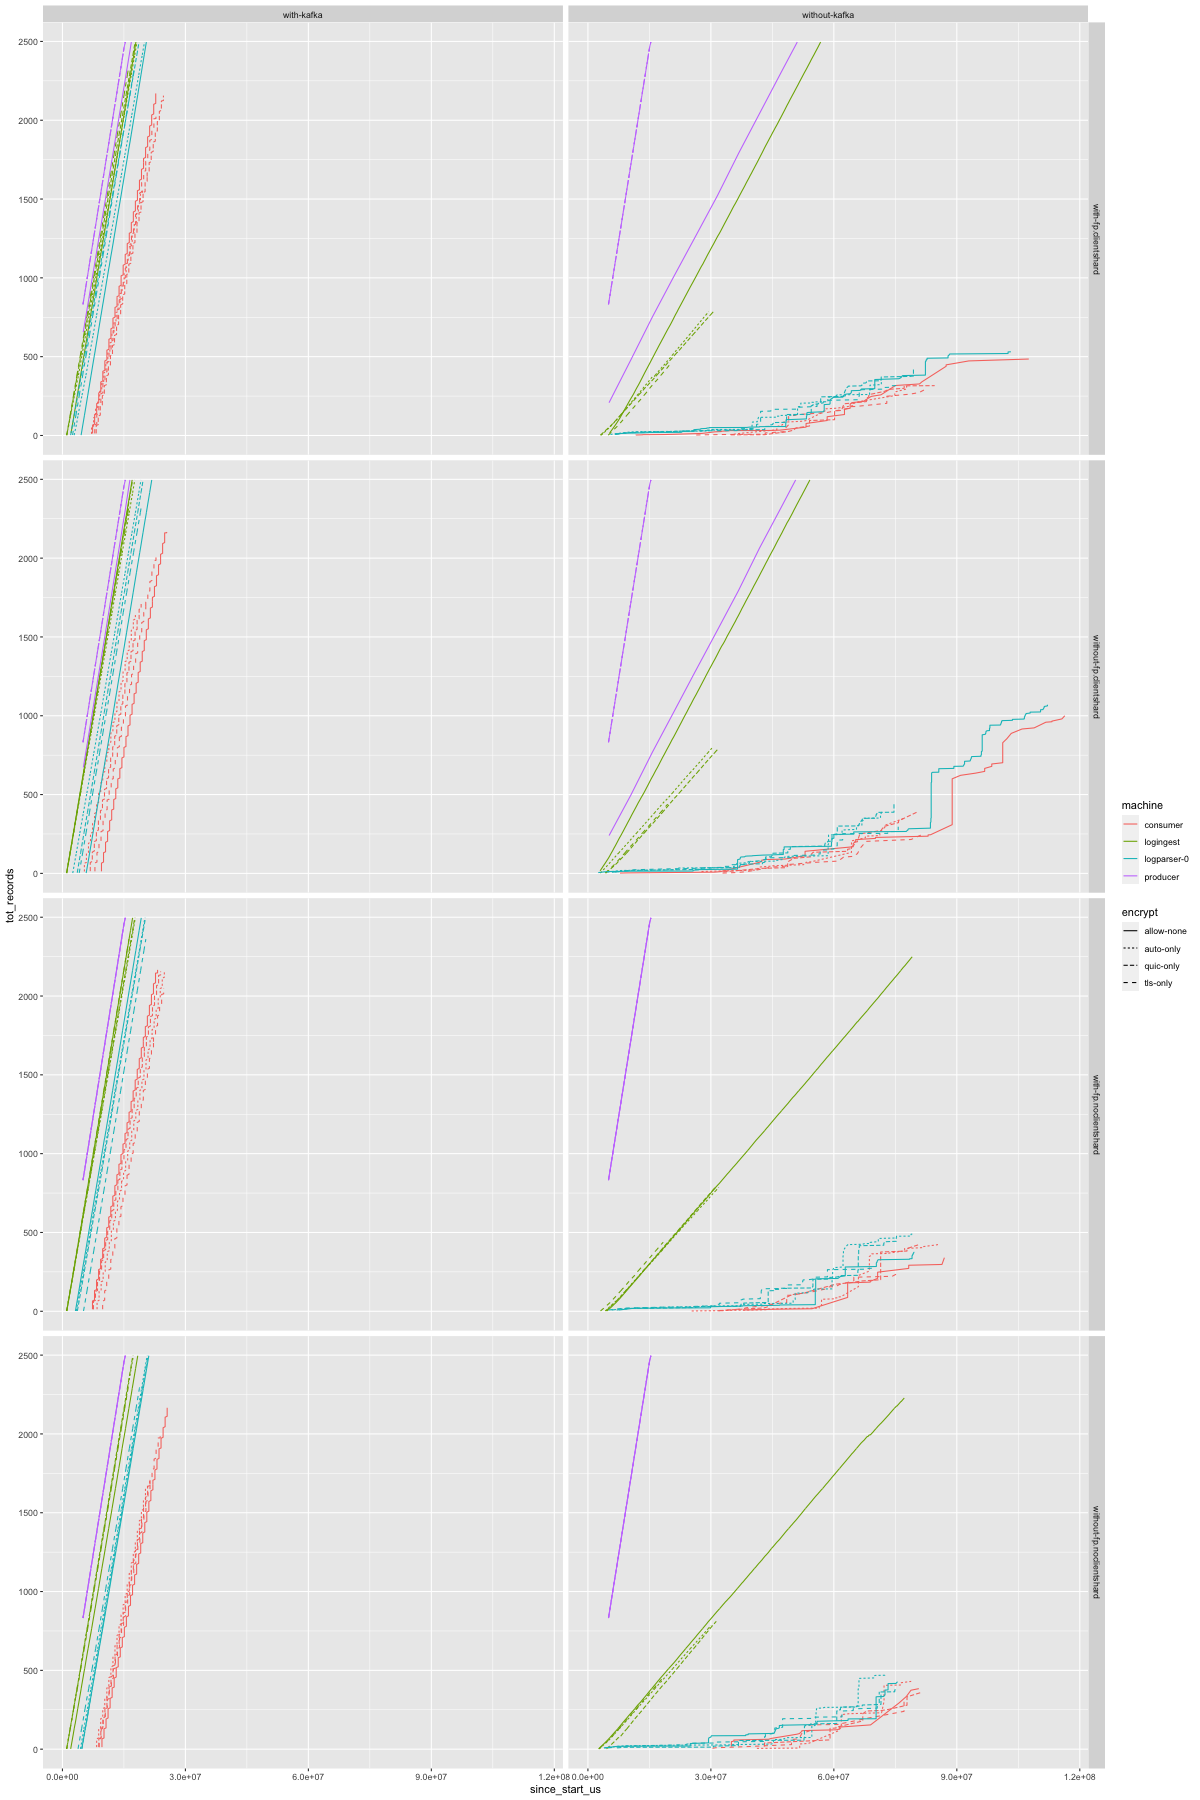

In [107]:
%%R -i df -w 1200 -h 1800

# zoom in
library(ggplot2)

ggplot(df, aes(x=since_start_us, y=tot_records, colour=machine, linetype=encrypt)) + 
    geom_line() +
    facet_grid(interaction(df$"local-fastpath",df$"producer-allow-client-sharding") ~ df$"pubsub-kafka")

In [ ]:
%%R -i df -w 1200 -h 1800

ggplot(df, aes(x=